# Emission Line Galaxy Classification

[Chris Richardson, Elon University](https://facstaff.elon.edu/crichardson17/) 

<i>Funding for this tutorial made possible through the [CATL Scholars Program](https://www.elon.edu/u/academics/catl/sotl/catl-scholars-program/)</i>

<i>This tutorial is intended for students to complete in groups. A version with solutions is available to instructors upon <a href="mailto:crichardson17@elon.edu">request</a>.</i>

## Objectives

- To explore classifying emission line galaxies according to the radiation source excitating gaseous clouds within each galaxy
- To understand how emission line ratios can help constrain excitation mechanisms
- To explore how models can highlight the strengths and weakness of various diagnostic diagrams
- To provide a foundation to explore your own questions about excitation mechanisms in galaxies

## Learning Outcomes

By the end of this tutorial you should be able to:

- Use emission line ratios to explore their diagnostic potential for finding AGN
- Use diagnostic diagrams to demarcate AGN and SF boundaries
- Use photoionization models to test the validity of diagnostic diagrams

## Prerequisites

- Computational
    - Basic Python skills (e.g., for loops, conditional statements, defining functions)
    - Basics of <code>matplotlib</code> visualization, SQL queries, and SciServer platform (e.g., see [here](https://escip.io/notebooks/sdss_tutorial_1.html))
    - Using the <code>[astropy](https://docs.astropy.org/en/stable/units/index.html)</code> package for fundamental constants and unit conversion

- Astrophysics
    - Introductory knowledge of the formation of [spectral lines](https://openstax.org/books/astronomy-2e/pages/5-5-formation-of-spectral-lines)
    - Basic understanding of the physical picture present in [star forming galaxies](http://skyserver.sdss.org/edr/en/proj/advanced/galaxies/spectra.asp) and [active galaxies](https://imagine.gsfc.nasa.gov/science/objects/active_galaxies1.html) (i.e., AGN)
    - Advanced conceptual understanding of using emission lines to probe spectral energy distributions

In [12]:
# Import relevant libraries

import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SkyServer as SkyServer # look up objects and generate images
import pandas as pd # data analysis 
import numpy as np # more data analysis
import seaborn as sns # plotting library
from matplotlib import pyplot as plt # another plotting library

In [13]:
# Make notebook have a clean appearance

pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

# Choosing a sample of galaxies

[<code>GalSpecLine</code>](http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+galSpecLine+U) and [<code>emissionLinesPort</code>](http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+emissionLinesPort+U) are examples of two schema available to search for emission line galaxies. The most common emission lines are featured in both schema, but there are several lines not cross listed between the two catalogs. The methods used for measuring the emission line strengths differ between the catalogs, each with their unique merits. We will use [GalSpecLine](http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+galSpecLine+U) for this tutorial, however <code>emissionLinesPort</code> could be used in a follow up project. 

While you can include as many or as little emission lines as you'd like in your query, you should always include the emission line flux errors and the galaxy redshifts. The errors on the emission line measurements enable you to improve the quality of your sample if only specific emission lines interest you. It is better to impose these restrictions after your query as it can dramatically reduce the sample size. The redshift of each galaxy is important because certain emission lines will shift into and outside the SDSS window of observation.

- At what $z$ will the shortest wavelength emission line shift into the observation window?
- At what $z$ will the longest wavelength emission line shift outside the observation window?

The SDSS aperture is fixed in size and is typically aligned with the nuclear center of each galaxy. 

- How might the size of the SDSS aperture tie into your ability to discern galaxy wide properties at certain redshifts?
- What sort of bias does this introduce into your results?

<b>Your answers to these questions:</b>
<br>
<br>
<br>
<br>
<br>

In [14]:
# Create a query to generate a sample of galaxies

query = 'SELECT TOP 10000 s.plate, s.fiberid, s.mjd, s.z, s.zwarning, '
query += 'g.oii_3726_flux, g.oii_3729_flux, ' #-- Gather possible emission lines of interest
query += 'g.neiii_3869_flux, g.h_delta_flux, '
query += 'g.h_gamma_flux, g.oiii_4363_flux, '
query += 'g.h_beta_flux, g.oiii_4959_flux, '
query += 'g.oiii_5007_flux, g.hei_5876_flux, '
query += 'g.oi_6300_flux, g.nii_6548_flux, '
query += 'g.h_alpha_flux, g.nii_6584_flux, '
query += 'g.sii_6717_flux, g.sii_6731_flux, '
query += 'g.ariii7135_flux, '
query += 'g.oii_3726_flux_err, g.oii_3729_flux_err, ' #-- Gather emission line errors
query += 'g.neiii_3869_flux_err, g.h_delta_flux_err, '
query += 'g.h_gamma_flux_err, g.oiii_4363_flux_err, '
query += 'g.h_beta_flux_err, g.oiii_4959_flux_err, '
query += 'g.oiii_5007_flux_err, g.hei_5876_flux_err, '
query += 'g.oi_6300_flux_err, g.nii_6548_flux_err, '
query += 'g.h_alpha_flux_err, g.nii_6584_flux_err, '
query += 'g.sii_6717_flux_err, g.sii_6731_flux_err, '
query += 'g.ariii7135_flux_err, '
query += 'e.bptclass '
query += 'FROM GalSpecLine AS g, SpecObj AS s, GalSpecExtra AS e ' 
query += 'WHERE '
query += 's.specobjid = g.specobjid '
query += 'AND s.specobjid = e.specobjid '
query += 'AND z BETWEEN 0.04 and 0.1 '#-- Lower limit needed for global parameters w/ small aperture
query += 'AND h_alpha_flux > h_alpha_flux_err*5 ' #-- Make sure Balmer lines have adequate S/N
query += 'AND h_beta_flux > h_beta_flux_err*5 '
query += 'AND h_alpha_flux_err > 0 ' #-- Consistency check
query += 'AND h_beta_flux_err > 0 '
query += 'AND sigma_balmer < 509.55 ' #-- Exclude the broad line emitting galaxies
query += 'AND s.class = \'GALAXY\' '  #-- Looking for galaxies, not stars
query += 'AND s.zwarning = 0 '
#print (query) # useful for debugging, remove first # to uncomment

# send query to CasJobs
gals = CasJobs.executeQuery(query, "dr16")

gals

,plate,fiberid,mjd,z,zwarning,oii_3726_flux,oii_3729_flux,neiii_3869_flux,h_delta_flux,h_gamma_flux,...,oiii_5007_flux_err,hei_5876_flux_err,oi_6300_flux_err,nii_6548_flux_err,h_alpha_flux_err,nii_6584_flux_err,sii_6717_flux_err,sii_6731_flux_err,ariii7135_flux_err,bptclass
0,266,4,51630,0.064656,0,39.057380,27.096570,2.468194,6.669699,12.437470,...,3.302969,2.745098,2.520172,1.046200,3.448143,3.155578,2.919328,2.860605,4.992754,3
1,266,120,51630,0.069341,0,-1.330543,7.919315,-0.333586,-1.529107,10.477300,...,2.545394,1.778672,1.680469,0.703648,2.371513,2.122362,2.055846,1.841887,3.126379,2
2,266,146,51630,0.052176,0,145.169700,184.163200,26.046470,67.026570,114.044300,...,4.271465,3.850465,3.498755,2.040700,10.994270,6.155217,4.846725,4.428813,3.586765,1
3,266,533,51630,0.085351,0,31.840760,28.041630,2.403825,12.097370,18.920390,...,2.793131,1.910691,1.961116,0.822471,3.265500,2.480760,2.806020,2.475492,2.315306,2
4,266,630,51630,0.073687,0,12.878990,21.359510,3.436489,0.142290,5.390950,...,1.988206,1.574178,1.350679,0.568662,2.131675,1.715214,1.609602,1.671389,1.910809,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1207,463,52672,0.055911,0,-0.273259,21.205140,0.332328,6.859152,4.029799,...,2.268165,2.104548,1.901967,0.799355,2.466196,2.411038,2.136849,2.025468,2.065840,2
9996,1207,512,52672,0.040428,0,168.423800,208.261600,16.263230,33.077510,53.475750,...,3.645575,2.059486,1.995668,0.826124,5.905511,2.491776,2.573609,2.407138,1.849287,1
9997,1208,202,52672,0.051229,0,75.635860,81.785600,4.387515,17.040500,28.414330,...,3.219081,2.728835,2.423338,1.162954,4.954031,3.507735,3.237844,3.007984,2.462693,1
9998,1208,490,52672,0.093831,0,37.472160,44.705480,2.661830,16.227150,30.224240,...,2.448881,1.810508,1.965327,0.843513,4.036311,2.544227,2.512585,2.451001,2.777650,1


# Using emission lines to find active galaxies

In the lecture-tutorial on emission line ratio diagnostics, you discovered how to find emission line ratios sensitive to the excitation source. In summary, ratios featuring emission lines with relatively different ionization potentials effectively probe the shape of the ionizing radiation field and therefore the excitation source (e.g., starlight, AGN).

As a trial run, let's explore how well the emission line ratio [O II] $\lambda$3727 / [Ne III] $\lambda$3869 separates star forming (SF) galaxies and AGN. N.B. [O II] $\lambda$3727 is actually the sum of the [O II] $\lambda$3726 and [O II] $\lambda$3729 doublet. 

- What are relavent ionization potentials for [O II] and [Ne III] line emission? 
- Would you expect AGN to display higher or lower [O II]/[Ne III] ratios compared to SF galaxies?

<b>Your answers to these questions:</b>
<br>
<br>
<br>
<br>
<br>

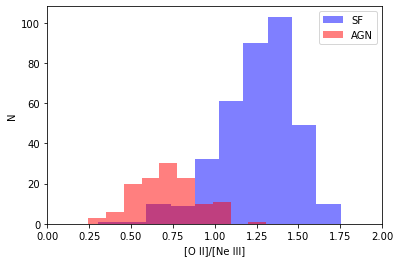

In [15]:
# Remove possible +/- inf values
gals_flux = gals[(gals['neiii_3869_flux']>0) & (gals['oii_3726_flux']>0) & (gals['oii_3729_flux']>0) 
                 & (gals['oi_6300_flux']>0) & (gals['oiii_5007_flux']>0)]

# Make sure relavent emission lines have well measured fluxes
quality_gals = gals_flux[(gals_flux['neiii_3869_flux']>5.0*gals_flux['neiii_3869_flux_err']) &
                (gals_flux['oii_3726_flux']>5.0*gals_flux['oii_3726_flux_err']) &
                (gals_flux['oii_3729_flux']>5.0*gals_flux['oii_3729_flux_err']) &
                (gals_flux['oi_6300_flux']>5.0*gals_flux['oi_6300_flux_err'])]

# Split the sample into AGN and SF galaxies
gals_sf = quality_gals[quality_gals['bptclass']==1]
gals_agn = quality_gals[(quality_gals['bptclass']==4)]

oii_doublet_sf = gals_sf['oii_3726_flux']+gals_sf['oii_3729_flux']
oii_doublet_agn = gals_agn['oii_3726_flux']+gals_agn['oii_3729_flux']

oii_neiii_sf = np.log10(oii_doublet_sf/gals_sf['neiii_3869_flux'])
oii_neiii_agn = np.log10(oii_doublet_agn/gals_agn['neiii_3869_flux'])

plt.hist(oii_neiii_sf,color='blue',alpha=0.5,label='SF')
plt.hist(oii_neiii_agn,color='red',alpha=0.5,label='AGN')
plt.xlim(0.0,2.0)
#plt.title('[O II]/[Ne III] as a function of galaxy classification')
plt.xlabel('[O II]/[Ne III]')
plt.ylabel('N')
plt.legend()
plt.show()


The histogram shows the number of galaxies in each bin as a function of galaxy classification. It is useful in telling us that the $N_{SF}$ > $N_{AGN}$ and that each distribution peaks at a differnt [O II]/[Ne III]. But, the actual location of those peaks is bit uncertain because the histogram is rather blocky.

The Python package <code>matplotlib</code> will try to select a bin width that results in a visually appealing histogram. We can adjust the number of bins, and therefore the bin width, using the "bins" kwarg. However, histograms will always appear bumpy and depend upon the endpoints of the bins. One way around this is to use a Keneral Density Estimator (KDE) plot, which you can read about [here](https://towardsdatascience.com/histograms-vs-kdes-explained-ed62e7753f12). We can use the "seaborn" package to make publicaton quality KDE plots that show a smooth distribution of our data. The plot now shows the <i>density</i> of galaxies rather than the <i>number</i> of galaxies.

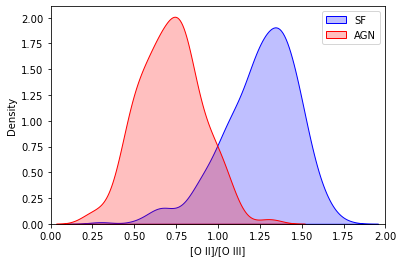

In [16]:
sns.kdeplot(oii_neiii_sf,color='Blue',fill=True,label='SF')
sns.kdeplot(oii_neiii_agn,color='Red',fill=True,label='AGN')
plt.xlim(0.0,2.0)
plt.xlabel('[O II]/[O III]')
plt.ylabel('Density')
plt.legend()
plt.show()

The KDE plot of [O II]/[Ne III] shows that no matter how we slice it, this ratio alone is not capable of separating SF and AGN excitation in galaxies. Let's assess the ability of [O III] $\lambda$5007 /[O I] $\lambda$6300 to act as an effective excitation diagnostic. Try generating a KDE plot for this emission line ratio in the space below and ask yourself the following questions.

- What are relavent ionization potentials for [O III] and [O I] line emission? 
- Would you expect AGN to display higher or lower [O III]/[O I] ratios compared to SF galaxies?
- Can you make a single cut to separate all galaxies with an AGN from those only experiencing SF?

<b>Your answers to these questions:</b>
<br>
<br>
<br>
<br>
<br>

In [17]:
# your code for KDE plot
#oiii_oi_sf = 
#oiii_oi_agn = 

# Diagnostic Diagrams

We can combine multiple line ratios in a diagram to increase their utility in separating AGN and SF activity. This assesses the shape of the inicident radiation field (starlight or AGN) at more energies than possible with a single emission line ratio. Let's combine [O II]/[Ne III] and [O III]/[O I] into a single plot.

In [18]:
plt.scatter(oii_neiii_sf,oiii_oi_sf,color='blue',label='SF',s=0.5,alpha=0.75)
plt.scatter(oii_neiii_agn,oiii_oi_agn,color='red',label='AGN',s=0.5,alpha=0.75)

plt.xlabel('[O II]/[Ne III]')
plt.ylabel(r'[O III]/[O I]')

plt.xlim(0.2,1.8)
plt.ylim(0.3,2.0)

plt.legend()

plt.show()

NameError: name 'oiii_oi_sf' is not defined

# Adding AGN/SF demarcations

The [O III]/[O I] vs. [O II]/[Ne III] diagram does a reasonable job in separating AGN and SF galaxies. We can make this separation more explicit by adding a demarcation line. Since we might want to generate this plot over and over, we can make define a function that will do it for us.

In [ ]:
def make_diagram():

    o2ne3_demarc = np.linspace(0.2, 1.19)
    o3o1_demarc = (0.055 / (o2ne3_demarc - 1.19)) + 1.35

    plt.scatter(oii_neiii_sf,oiii_oi_sf,color='blue',label='SF',s=0.5,alpha=0.75)
    plt.scatter(oii_neiii_agn,oiii_oi_agn,color='red',label='AGN',s=0.5,alpha=0.75)

    plt.plot(o2ne3_demarc,o3o1_demarc,'k')

    plt.xlabel('[O II]/[Ne III]')
    plt.ylabel(r'[O III]/[O I]')

    plt.xlim(0.2,1.8)
    plt.ylim(0.3,2.0)

    plt.legend()

######    

make_diagram()
plt.show()

# Justifying diagnostic diagrams with models

Up until this point, we have been using observed galaxies flagged as an AGN or star forming galaxy in the <code>GalSpecExtra</code>. While we would like to take this information for granted, it is important to note these tags are based on a set of assumptions that may or may not hold for all galaxies. We can use photoionization models to understand the limits of these AGN/SF distinctions and our newly created diagnostics diagram. 

Photoionization models predict the observed emission line spectrum for gas clouds illuminated by an AGN or starlight in a galaxy. The set that we will use comes from [this paper](https://iopscience.iop.org/article/10.3847/1538-4357/ac510c) and a link to the simulated emission region data has been provided on Moodle. To make the visualization easier, we can restrict the model parameter space to regions that we're interested in exploring. A brief description of the parameters is given below along with accepted values within the grid.

<code>LOGU</code> - dimensionaless quantity (ionization parameter) specifying the ionization level of the gas clouds\
options: -4.0 to -0.5 in 0.25 increments

<code>LOGZ</code> - metallicity of the gas clouds relative to solar metallicity\
options: [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0]

<code>AGNFRAC</code> - the fraction of AGN excitation as opposed to starlight excitation\
options: [0.0, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0] 

Let's see how the emission line predictions compare to our observed galaxies on the diagnostic diagram when we select a simulation with 100% AGN excitation and Z = 0.2 Z$_{\odot}$.

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1vQrGvdOf2w9VAu7F0lub5tEAi75cIMm4' -O model_file

model_grid = pd.read_csv('model_file', delimiter=',')

#print (model_grid.columns) # useful to check out the column names in the file

# function to restrict the model parameter space
def apply_limits(grid,f_agn,U,Z):
    
    grid = grid[(grid['AGNFRAC'] == f_agn) & (round(grid['LOGZ'],5) == round(np.log10(Z),5)) \
                & (grid['MIXING'] == ' coincident') & (grid['LOGU'] >= U[0]) & (grid['LOGU'] <= U[1])]
    
    return grid

U = [-3.75,-2.75] # range of ionization parameter
f_agn = 1.0
Z = 0.2

agn_models = apply_limits(model_grid,f_agn,U,Z)
#print (agn_models)

model_x = np.log10((agn_models[' \'O__2_372603A\'']+agn_models[' \'O__2_372881A\''])/agn_models[' \'NE_3_386876A\''])
model_y = np.log10(agn_models[' \'O__3_500684A\'']/agn_models[' \'O__1_630030A\''])

make_diagram()

plt.plot(model_x,model_y,color='Green',marker='o')

plt.show()

The AGN model assuming 0.2 Z$_{\odot}$ lies in the AGN part of our diagram and including a range of ionization parameter covers some of the variation in the region. It seems that the models preliminarily suggest the galaxies flagged as AGN really are AGN and the diagnostic diagram can pick them out. In the cells below, determine if this is a robust result by answering the following questions.

- Do all of the 100% AGN simulations fall within the AGN part of the diagnostic diagram?
- If so, what range of ionization parameters and metallicities do the observed AGN span? If not, what values disagree with our chosen demarcations?
- Do all of the purely SF simulations fall within the SF part of the diagnostic diagram?
- If so, what range of ionization parameters and metallicities do the observed SF galaxies span? If not, what values disagree with our chosen demarcations?

In [ ]:
# your code to answer the questions above

# The BPT Diagram

The diagnostic diagram that we have developed does have it's limitations. For example, both of the [O II] and [Ne III] emission lines are unavailable for low-$z$ galaxies because they fall outside the SDSS observing window. This means that we're unable to identify AGN activity for local galaxies. Another limitation is that some of the emission lines can be rather weak, making a reliable detection difficult. We can quantify this by looking at much our sample reduces down after applying our S/N cut.

In [ ]:
print ('Fraction of initial SF galaxies included after S/N cut: ',
       "{:.3}".format(len(gals_sf)/len(gals[gals['bptclass']==1])))
print ('Fraction of initial AGN galaxies included after S/N cut: ',
       "{:.3}".format(len(gals_agn)/len(gals[gals['bptclass']==4])))

Therein lies the problem: most galaxies only have a handful of reliable emission lines measurements. This is one reason why the diagnostic diagram we have been analyzing isn't a popular choice in research literature even though it does a reasonable job of distinguishing between AGN and star forming galaxies.

The so-called "gold standard" for classifying AGN with optical spectroscopy is known as the "BPT" diagram, named after the authors that developed it in [this paper](https://ui.adsabs.harvard.edu/abs/1981PASP...93....5B/abstract). The BPT diagram uses emission line ratios from [O III] $\lambda$5007, [N II] $\lambda$6584, H$\beta$, and H$\alpha$, all of which are known as "strong lines" since they're strong enough to be reliably measured in most galaxies. Using strong lines for diagnostics drastically improves the number of galaxies we can include in a sample.

In [ ]:
gals_flux = gals[(gals['oiii_5007_flux']>0) & (gals['nii_6584_flux']>0)]

quality_gals = gals_flux[(gals_flux['oiii_5007_flux']>5.0*gals_flux['oiii_5007_flux_err']) &
                (gals_flux['nii_6584_flux']>5.0*gals_flux['nii_6584_flux_err'])]

gals_sf = quality_gals[quality_gals['bptclass']==1 | (quality_gals['bptclass']==2)]
gals_agn = quality_gals[(quality_gals['bptclass']==4)]

print ('Fraction of initial SF galaxies included after S/N cut: ',
       "{:.3}".format(len(gals_sf)/len(gals[gals['bptclass']==1])))
print ('Fraction of initial AGN galaxies included after S/N cut: ',
       "{:.3}".format(len(gals_agn)/len(gals[gals['bptclass']==4])))

The BPT diagram remains a hot topic in academic literature today. In fact, the <code>GalSpecExtra</code> schema actually uses the BPT diagram to classify galaxies as AGN or star forming. If we use the standard demarcations from literature, it is no surprise in the plot the below that all of the AGN and star forming galaxies are perfectly separated. There is even an additional class of galaxies known as "composites" that are thought to represent a transition state between purly star forming galaxies and those excited purely by an AGN.

In [ ]:
def make_bpt_plot():
    
    gals_comp = quality_gals[(quality_gals['bptclass']==3)]

    oiii_Hb_sf = np.log10(gals_sf['oiii_5007_flux']/gals_sf['h_beta_flux'])
    oiii_Hb_agn = np.log10(gals_agn['oiii_5007_flux']/gals_agn['h_beta_flux'])
    oiii_Hb_comp = np.log10(gals_comp['oiii_5007_flux']/gals_comp['h_beta_flux'])

    nii_Ha_sf = np.log10(gals_sf['nii_6584_flux']/gals_sf['h_alpha_flux'])
    nii_Ha_agn = np.log10(gals_agn['nii_6584_flux']/gals_agn['h_alpha_flux'])
    nii_Ha_comp = np.log10(gals_comp['nii_6584_flux']/gals_comp['h_alpha_flux'])

    plt.scatter(nii_Ha_sf,oiii_Hb_sf,color='blue',label='SF',s=0.5,alpha=0.75)
    plt.scatter(nii_Ha_agn,oiii_Hb_agn,color='red',label='AGN',s=0.5,alpha=0.75)
    plt.scatter(nii_Ha_comp,oiii_Hb_comp,color='magenta',label='Comp',s=0.5,alpha=0.75)

    comp_n2ha = np.linspace(-2.5,-0.1,100)
    comp_o3hb = 0.61/(comp_n2ha-0.05)+1.3
    plt.plot(comp_n2ha,comp_o3hb,color='k',linestyle='--',linewidth=1.0)

    agn_n2ha = np.linspace(-2.5,0.3,100)
    agn_o2hb = 0.61/(agn_n2ha-0.47)+1.19
    plt.plot(agn_n2ha,agn_o2hb,color='k',linewidth=1.0)

    plt.xlabel(r'[N II]/H$\alpha$')
    plt.ylabel(r'[O III]/H$\beta$')

    plt.xlim(-1.5,0.5)
    plt.ylim(-1.0,1.25)

    plt.legend()

######
    
make_bpt_plot()
plt.show()

All of the strong lines on the BPT diagram fall within the SDSS observation window for both local galaxies and those at higher redshifts. Combined with the superior statistics shown above, this makes the BPT diagram a suitable choice for tracing galaxy evolution. We can return to the photoionization models to investigate how a purely star forming model compares to the selected observations.

In [ ]:
make_bpt_plot()

U = [-3.75,-2.75]
f_agn = 0.0
Z = 0.4

agn_models = apply_limits(model_grid,f_agn,U,Z)

#print (model_grid.columns) # useful to check out the column names in the file

model_x = np.log10(agn_models[' \'N__2_658345A\'']/agn_models[' \'H__1_656281A\''])
model_y = np.log10(agn_models[' \'O__3_500684A\'']/agn_models[' \'H__1_486133A\''])

plt.plot(model_x,model_y,color='Cyan',marker='o')

plt.show()

All diagnostic diagrams have their limitations and it is important to keep the limitations in mind when interpreting results. In the space below, use the photionization models to explore the limitations of the BPT diagram in the same way that you previously explored the limitations of the [O III]/[O I] vs. [O II]/[Ne III] diagram. 

In [ ]:
# your code to compare photoionization models to selected observations

# Follow Up Questions

Developing new diagnostic diagrams to separate AGN and SF galaxies remains a trendy topic in academic research. This Lecture-Tutorial has laid the foundation for you to investigate this yourself. A sample of potential follow up questions is given below, but don't let these limit your curiousity.

- What are the effects of selecting models with non-binary $f_{AGN}$?
- We know where BPT classfied AGN lie on the [O III]/[O I] vs. [O II]/[Ne III] diagram, but what about vice-versa, and what does this tell you about using only one diagram to find AGN?
- What other diagrams can effectively seperate AGN and SF galaxies?